In [3]:
import geopandas as gpd
import plotly.io as pio
from glacier.data.data_fetching import repo_root
from glacier.visualisation import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


root = repo_root()
gdf = gpd.read_parquet(root / "data" / "processed" / "glims_clean.parquet")
df = pd.DataFrame(gdf.drop(columns="geometry")) # moins lourd pour certains graphes

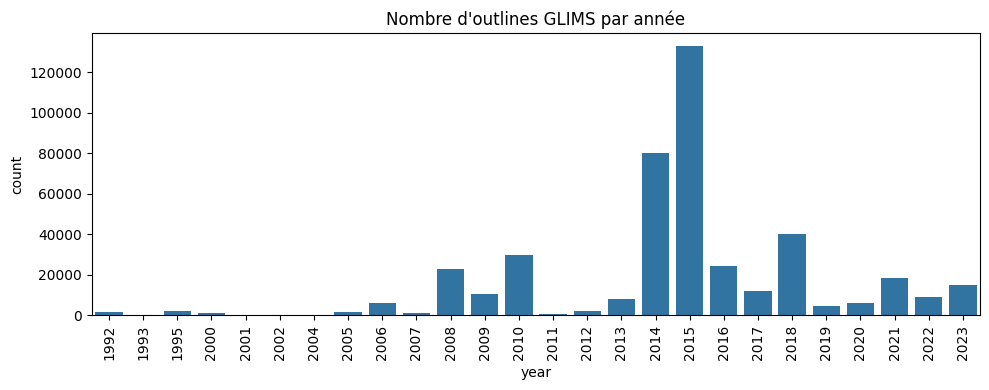

In [4]:
df["year"] = df["anlys_time"].dt.year

plt.figure(figsize=(10,4))
sns.countplot(x="year", data=df, color="C0")
plt.title("Nombre d'outlines GLIMS par année")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

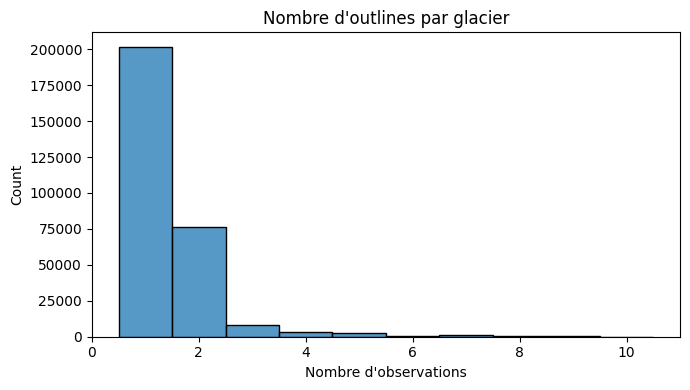

In [8]:
counts = df.groupby("glac_id").size()

plt.figure(figsize=(7,4))
sns.histplot(counts[counts <= 10], bins=10, discrete=True)
plt.title("Nombre d'outlines par glacier")
plt.xlabel("Nombre d'observations")
plt.tight_layout()
plt.show()

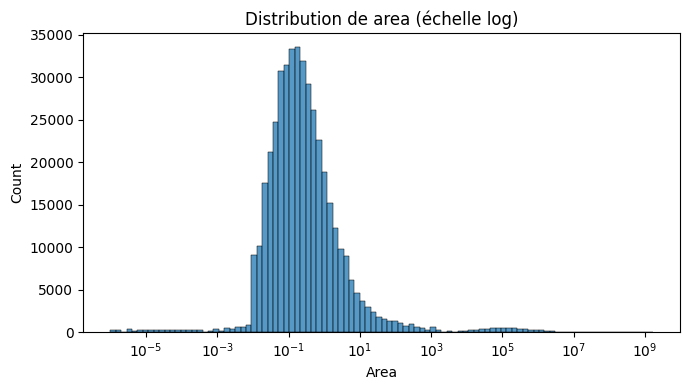

In [9]:
plt.figure(figsize=(7,4))
sns.histplot(df["area"], bins=100, log_scale=True)
plt.title("Distribution de area (échelle log)")
plt.xlabel("Area")
plt.tight_layout()
plt.show()

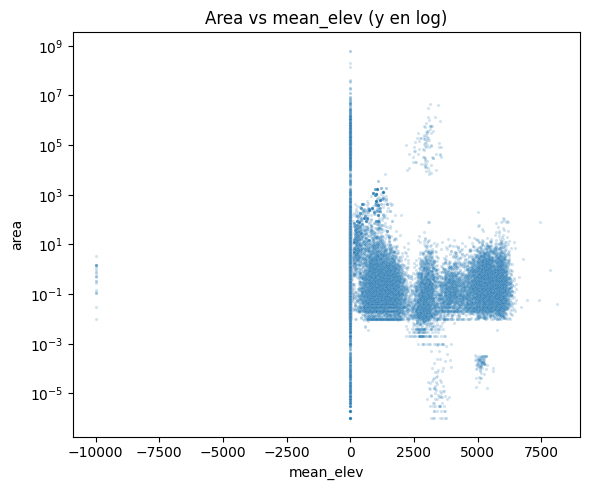

In [10]:
sample = df.sample(50000, random_state=0) if len(df) > 50000 else df

plt.figure(figsize=(6,5))
sns.scatterplot(data=sample, x="mean_elev", y="area", s=5, alpha=0.2)
plt.yscale("log")
plt.title("Area vs mean_elev (y en log)")
plt.tight_layout()
plt.show()

Nombre de lignes incohérentes (altitudes): 165277


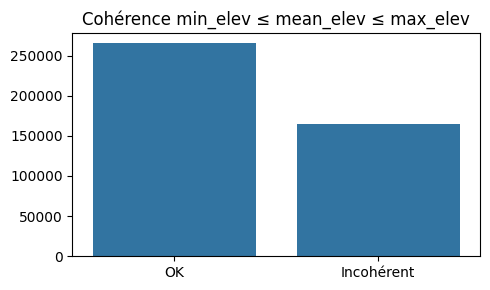

In [11]:
bad = ~((df["min_elev"] <= df["mean_elev"]) & (df["mean_elev"] <= df["max_elev"]))
print("Nombre de lignes incohérentes (altitudes):", bad.sum())

plt.figure(figsize=(5,3))
sns.barplot(x=["OK", "Incohérent"], y=[(~bad).sum(), bad.sum()])
plt.title("Cohérence min_elev ≤ mean_elev ≤ max_elev")
plt.tight_layout()
plt.show()

C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_16164\1092702554.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent["geometry"] = cent.geometry.centroid


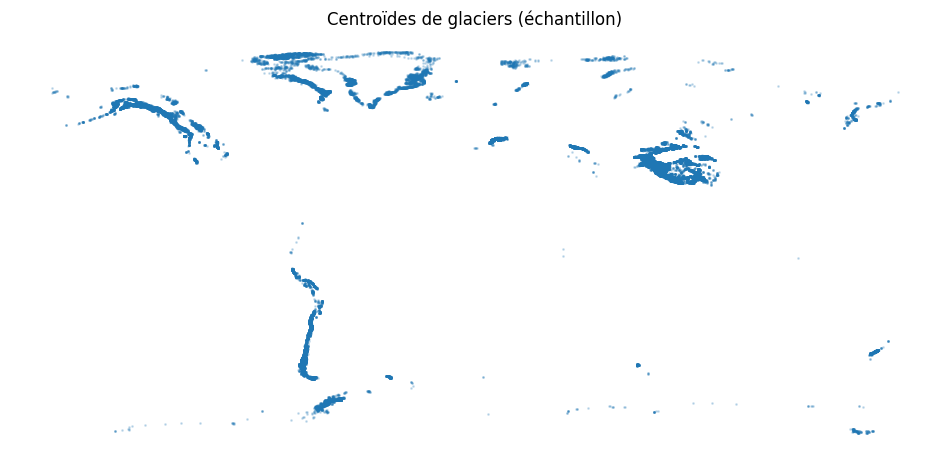

In [12]:
cent = gdf[["geometry"]].copy()
cent["geometry"] = cent.geometry.centroid
cent = cent.set_geometry("geometry")

ax = cent.sample(50000, random_state=0).plot(figsize=(12,6), markersize=1, alpha=0.2)
ax.set_title("Centroïdes de glaciers (échantillon)")
ax.set_axis_off()
plt.show()

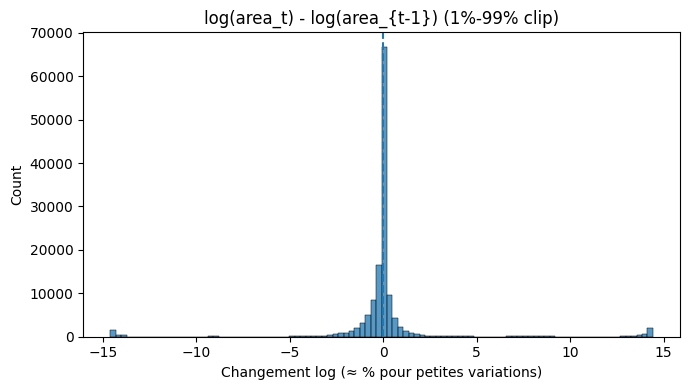

In [21]:
tmp = df[["glac_id","anlys_time","area"]].dropna().sort_values(["glac_id","anlys_time"])
tmp["prev_area"] = tmp.groupby("glac_id")["area"].shift(1)
tmp = tmp.dropna(subset=["prev_area"])
tmp = tmp[(tmp["area"] > 0) & (tmp["prev_area"] > 0)]

tmp["log_change"] = np.log(tmp["area"]) - np.log(tmp["prev_area"])

lo, hi = tmp["log_change"].quantile([0.01, 0.99])
x = tmp["log_change"].clip(lo, hi)

plt.figure(figsize=(7,4))
sns.histplot(x, bins=100)
plt.axvline(0, linestyle="--")
plt.title("log(area_t) - log(area_{t-1}) (1%-99% clip)")
plt.xlabel("Changement log (≈ % pour petites variations)")
plt.tight_layout()
plt.show()

In [24]:
pio.renderers.default = "browser"  # normalement on utiliserait "notebook_connected" pour avoir le graphe sous la cellule mais ça ne marche pas bien 

fig = build_glacier_mapbox_dropdown(gdf, REGIONS, start="Alpes", max_polys=2000)
fig.show(config={"scrollZoom": True})